In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from scipy import signal

In [3]:
#d = pd.read_csv('../data/data_2019-12-31-03.53.43.csv') # smaller size
d = pd.read_csv('../data/data_2019-12-31-05.18.27.csv') # size bigger

In [4]:
des=pd.read_csv('../design_sf.csv')

In [5]:
des_dict={row[1]['id']: row[1]['sfreq'] for row in des[['id', 'sfreq']].iterrows()}

In [6]:
des_dict

{1: 3, 2: 12, 3: 6}

In [7]:
d.shape

(106546, 6)

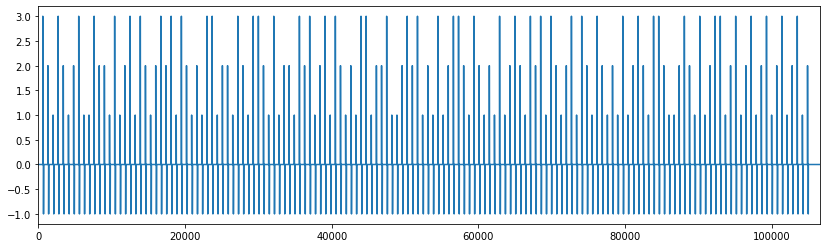

In [8]:
plt.figure(figsize=(14, 4))
(d['Marker']).astype(np.int).plot()

In [9]:
# diff_indx= np.where((d['Marker']).astype(np.int).diff()>0)[0]
# first_diff = diff_indx[0]
# last_diff = diff_indx[len(diff_indx)-1]
# d = d.loc[first_diff-40:last_diff+400,:]

In [10]:
t = d.timestamps

In [11]:
eeg = np.array(d.iloc[:, 1:5])
tag = np.array(d.loc[:, 'Marker'])

In [12]:
prev = 0
for i, t in enumerate(tag):
    if t != 0:
        prev = t
    elif i != 0:
        tag[i] = prev

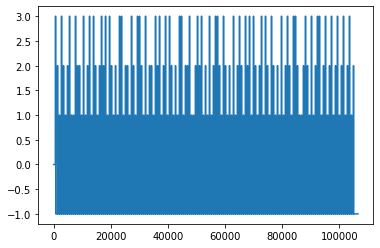

In [13]:
plt.plot(tag)
plt.show()

In [14]:
eeg.shape

(106546, 4)

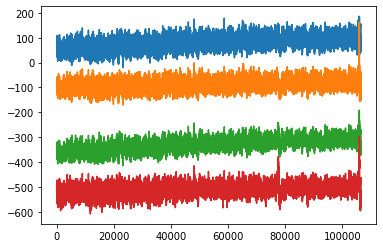

In [15]:
plt.plot(eeg)

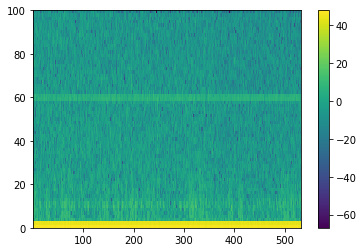

In [16]:
_ = plt.specgram(eeg[:, 2], NFFT=128, Fs=200, noverlap=64)
plt.colorbar()

In [17]:
# remove DC offset
hp_cutoff_Hz = 1.0
fs_Hz = 200
b, a = signal.butter(2, hp_cutoff_Hz/(fs_Hz / 2.0), 'highpass')
eeg = signal.lfilter(b, a, eeg, axis=0)

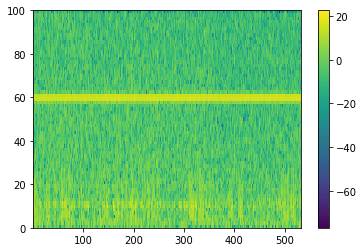

In [18]:
_ = plt.specgram(eeg[:, 0], NFFT=128, Fs=200, noverlap=64)
plt.colorbar()

In [19]:
# remove notch
notch_freq_Hz = np.array([60.0])
freq_Hz = notch_freq_Hz
bp_stop_Hz = freq_Hz + 3.0*np.array([-1, 1])  # set the stop band
b, a = signal.butter(3, bp_stop_Hz/(fs_Hz / 2.0), 'bandstop')
eeg = signal.lfilter(b, a, eeg, axis=0)
print("Notch filter removing: " + str(bp_stop_Hz[0]) + "-" + str(bp_stop_Hz[1]) + " Hz")

Notch filter removing: 57.0-63.0 Hz


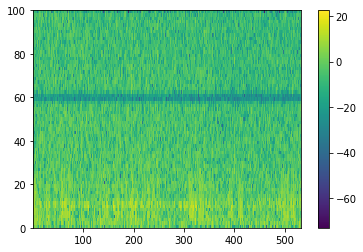

In [20]:
_ = plt.specgram(eeg[:, 0], NFFT=128, Fs=200, noverlap=64)
plt.colorbar()

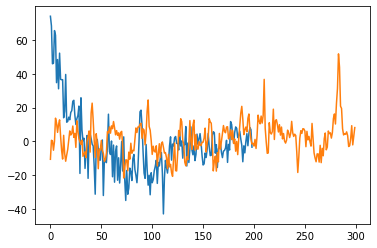

In [21]:
plt.plot(eeg[1:200, 0])
plt.plot(eeg[-300:, 0])

In [22]:
eeg = eeg[50:,]
tag = tag[50:,]

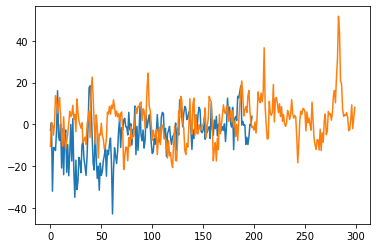

In [23]:
plt.plot(eeg[1:200, 0])
plt.plot(eeg[-300:, 0])

In [24]:
# def smooth(self,x,window_len=11,window='hanning'):
#     if x.ndim != 1:
#         raise ValueError, "Smooth only accepts 1 dimension arrays."
#     if x.size < window_len:
#         raise ValueError, "Input vector needs to be bigger than window size."
#     if window_len<3:
#         return x
#     if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
#         raise ValueError, "Invalid window type in smooth(). Must be one of 'flat', 'hanning', 'hamming', 'bartlett', or 'blackman'"
#     s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
#     if window == 'flat': #moving average
#         w=np.ones(window_len,'d')
#     else:
#         w=eval('np.'+window+'(window_len)')
#     y=np.convolve(w/w.sum(),s,mode='valid')
#     return y

In [25]:
# filter from 5 to 35 Hz, helps remove 60Hz noise and replicates paper
## also helps remove the DC line noise (baseline drift)
## 100 is half the sampling rate (250Hz/2)

# not sure to use 3 (EEG Grunt) or 4 (Berkeley course ) ?

b, a = signal.butter(3, (5.0/100, 50.0/100), btype='bandpass') 
b, a

(array([ 0.13006301,  0.        , -0.39018904,  0.        ,  0.39018904,
         0.        , -0.13006301]),
 array([ 1.        , -2.8083373 ,  3.15605525, -2.13962297,  1.14221748,
        -0.37178976,  0.02666632]))

In [26]:
#eeg_f = eeg
eeg_f = signal.lfilter(b, a, eeg, axis=0)

In [27]:
t_sec = np.arange(len(eeg[:, 0])) / fs_Hz

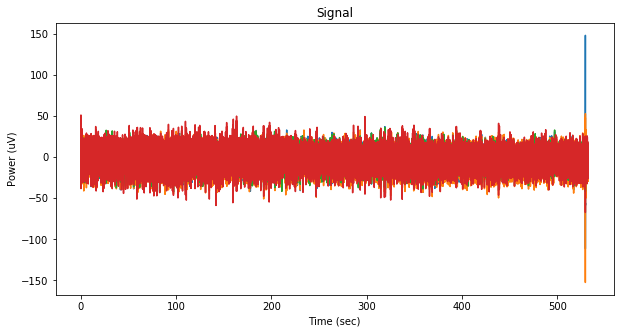

In [28]:
plt.figure(figsize=(10,5))
plt.subplot(1,1,1)
#plt.plot(t_sec,np.mean(eeg,axis=1))
plt.plot(t_sec,eeg_f)
plt.xlabel('Time (sec)')
plt.ylabel('Power (uV)')
plt.title('Signal')
plt.show()

In [29]:
import matplotlib.mlab as mlab

In [41]:
def plot_specgram(eeg, ch):
    NFFT=512
    Fs=200
    overlap=NFFT - int(0.25 * fs_Hz)
    spec_PSDperHz, spec_freqs, spec_t = mlab.specgram(np.squeeze(eeg),
                                   NFFT=NFFT,
                                   window=mlab.window_hanning,
                                   Fs=fs_Hz,
                                   noverlap=overlap
                                   )
    # convert the units of the spectral data
    spec_PSDperBin = spec_PSDperHz * fs_Hz / float(NFFT)
    f_lim_Hz = [0, 50]   # frequency limits for plotting
    #plt.figure(figsize=(10,5))
    #ax = plt.subplot(1,1,1)
    plt.pcolor(spec_t, spec_freqs, 10*np.log10(spec_PSDperBin), cmap='hot')  # dB re: 1 uV
    plt.colorbar()
    plt.clim([-25,26])
    plt.xlim(spec_t[0], spec_t[-1]+1)
    plt.ylim(f_lim_Hz)
    plt.xlabel('Time (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Spectrogram of Channel {}'.format(ch))

    # add annotation for FFT Parameters
    ax.text(0.025, 0.95,
        "NFFT = " + str(NFFT) + "\nfs = " + str(int(fs_Hz)) + " Hz",
        transform=ax.transAxes,
        verticalalignment='top',
        horizontalalignment='left',
        backgroundcolor='w')
    #plt.show()

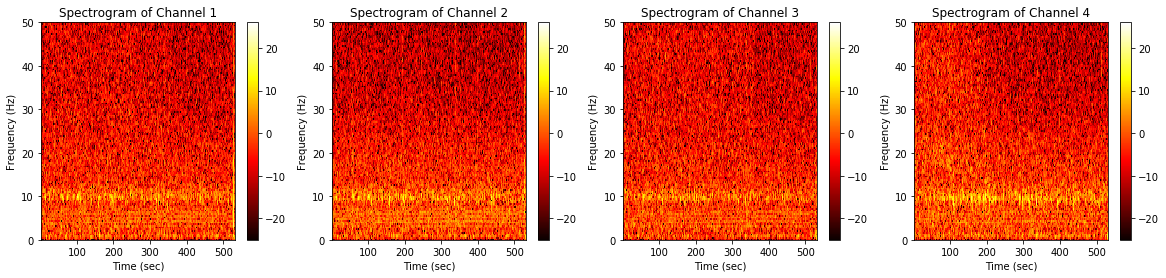

In [44]:
plt.figure(figsize=(20,4))
plt.subplot(1,4,1)
plot_specgram(eeg[:,0],1)
plt.subplot(1,4,2)
plot_specgram(eeg[:,1],2)
plt.subplot(1,4,3)
plot_specgram(eeg[:,2],3)
plt.subplot(1,4,4)
plot_specgram(eeg[:,3],4)
#plt.show()
plt.savefig('./spectrograms.png', pad_inches=0)

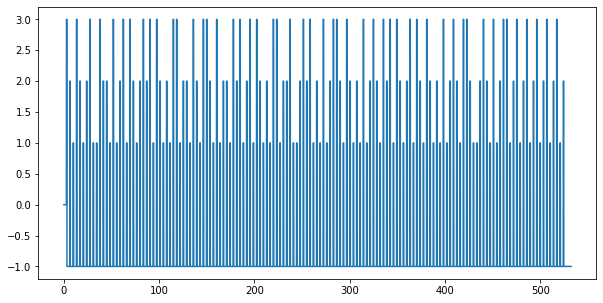

In [34]:
plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
plt.plot(t_sec, tag)
plt.show()

Text(0.5, 1.0, 'Power Spectrum')

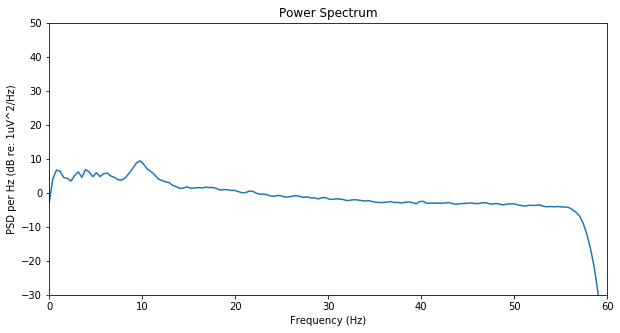

In [35]:
spectrum_PSDperHz = np.mean(spec_PSDperHz,1)
plt.figure(figsize=(10,5))
plt.plot(spec_freqs, 10*np.log10(spectrum_PSDperHz))  # dB re: 1 uV
plt.xlim((0,60))
plt.ylim((-30,50))
plotname = 'Channel Spectrum Average FFT Plot'
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD per Hz (dB re: 1uV^2/Hz)')
plt.title("Power Spectrum")

Text(0.5, 1.0, 'Trend Graph of EEG Amplitude over Time')

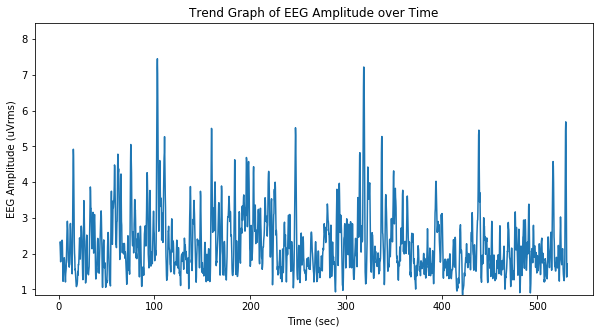

In [36]:
start_freq, end_freq, band  = 8,12,"Alpha"
bool_inds = (spec_freqs > start_freq) & (spec_freqs < end_freq)
band_power = np.sqrt(np.amax(spec_PSDperBin[bool_inds, :], 0))
plt.figure(figsize=(10,5))
plt.plot(spec_t,band_power)
plt.ylim([np.amin(band_power), np.amax(band_power)+1])
# plt.xlim(len(x)/config['sample_block'])
plt.xlabel('Time (sec)')
plt.ylabel('EEG Amplitude (uVrms)')
plt.title('Trend Graph of EEG Amplitude over Time')

In [37]:
from sklearn.decomposition import FastICA
ica = FastICA()
sources = ica.fit_transform(eeg_f)
means = ica.mean_.copy()
mixing = ica.mixing_.copy()

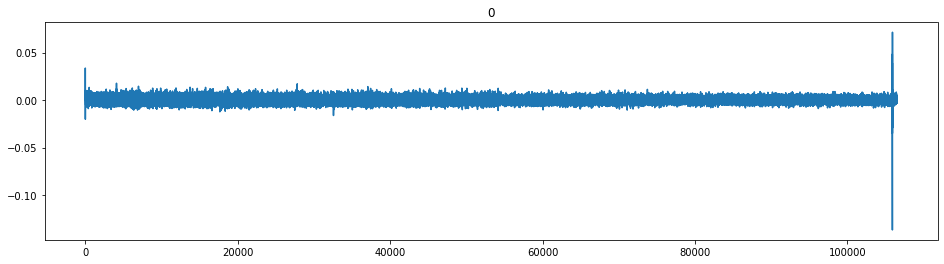

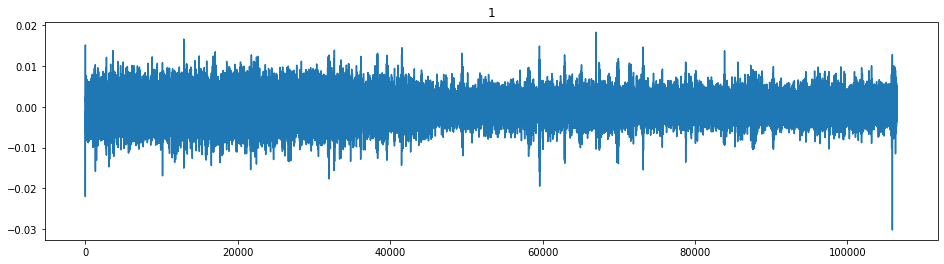

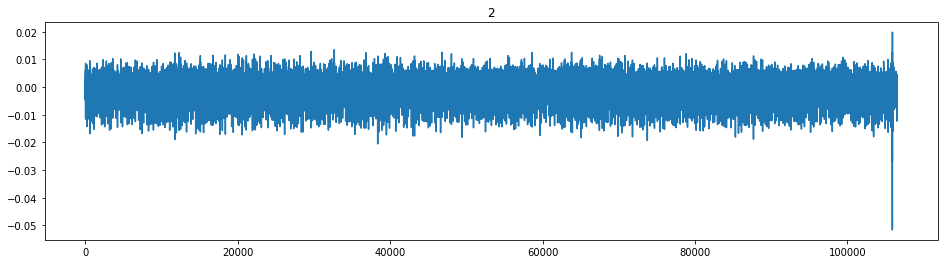

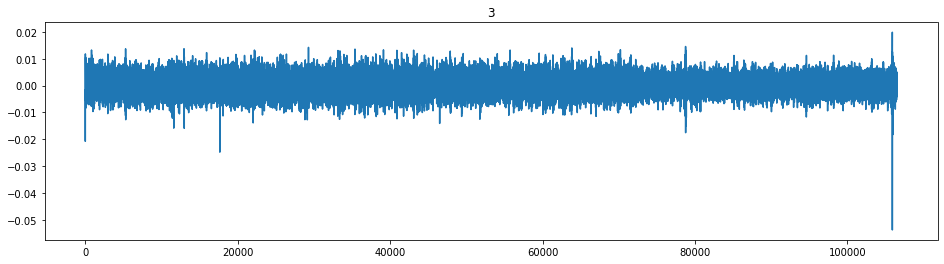

In [38]:
## look at the plots to find the eyeblink component
## TODO: make a more robust eyeblink component finder
for i in range(ica.components_.shape[0]):
    plt.figure(figsize=(16,4))
    plt.plot(sources[:, i])
    plt.title(i)

In [37]:
# eye_blinks_ix = 3
# mixing[:, eye_blinks_ix] = 0 # setting eyeblink component to 0
# eeg_ff = sources.dot(mixing.T) + means # this is the ICA inverse transform

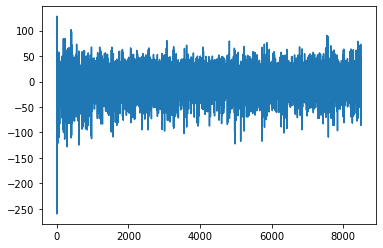

In [80]:
plt.figure()
plt.plot(eeg_f[500:9000, 0])

#plt.figure()
#plt.plot(eeg_ff[:8500, 0])

In [38]:
# word_dict = {}
# for i in range(words.shape[0]):
#     d = dict(words.ix[i])
#     word_dict[d['id']] = d

In [45]:
word_starts = []
prev_t = None

for i, t in enumerate(tag):
    if t != -1 and t != 0 and t != prev_t:
        w = t #word_dict[t]
        word_starts.append( {'index': i, 
                             'word': t,
                             'dict': w} )
    prev_t = t

In [46]:
## this confirms that there's ~2.5 seconds between words
np.diff([x['index'] for x in word_starts]) / 200.0

array([3.52 , 3.48 , 3.5  , 3.49 , 3.52 , 3.505, 3.495, 3.505, 3.5  ,
       3.485, 3.515, 3.505, 3.495, 3.495, 3.51 , 3.49 , 3.5  , 3.505,
       3.495, 3.505, 3.5  , 3.5  , 3.5  , 3.505, 3.495, 3.495, 3.51 ,
       3.495, 3.495, 3.51 , 3.49 , 3.5  , 3.505, 3.495, 3.485, 3.52 ,
       3.5  , 3.5  , 3.505, 3.495, 3.495, 3.51 , 3.485, 3.515, 3.495,
       3.495, 3.505, 3.5  , 3.5  , 3.5  , 3.505, 3.495, 3.475, 3.53 ,
       3.49 , 3.5  , 3.51 , 3.5  , 3.5  , 3.505, 3.495, 3.495, 3.505,
       3.495, 3.5  , 3.505, 3.495, 3.505, 3.5  , 3.5  , 3.5  , 3.505,
       3.495, 3.495, 3.51 , 3.49 , 3.5  , 3.505, 3.495, 3.505, 3.5  ,
       3.5  , 3.5  , 3.505, 3.495, 3.5  , 3.505, 3.495, 3.495, 3.51 ,
       3.49 , 3.5  , 3.505, 3.5  , 3.5  , 3.5  , 3.5  , 3.5  , 3.505,
       3.495, 3.495, 3.51 , 3.49 , 3.5  , 3.505, 3.495, 3.485, 3.515,
       3.505, 3.5  , 3.505, 3.495, 3.485, 3.52 , 3.495, 3.495, 3.51 ,
       3.49 , 3.5  , 3.505, 3.5  , 3.5  , 3.5  , 3.5  , 3.5  , 3.505,
       3.495, 3.495,

In [47]:
trial_types = np.array([w['word'] for w in word_starts])

In [48]:
t_before = 0.5
t_after  = 1.0
eeg_trials = np.zeros((4, len(word_starts), int((t_before+t_after)*200)))
time = np.arange(0, eeg_trials.shape[2], 1) / 200.0 - t_before

In [49]:
for c in range(4):
    for i in range(len(word_starts)):
        d = word_starts[i]
        start = d['index']
        if start < 100:
            continue
        # 100 samples = 0.5s, 400 samples = 2.0 s
        # we want 0.5s before the stimulus presentation and 2.0 seconds after
        eeg_trials[c, i, :] = eeg_f[int(start-t_before*200):int(start+t_after*200), c] 

In [50]:
# for c in range(4):
#     plt.figure(figsize=(14, 4))
#     _ = plt.plot(time, np.mean(eeg_trials[c], axis=0))
#     plt.title('')

In [51]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [53]:
N_AVG = 10
eeg_trials_smooth = np.apply_along_axis(moving_average, axis=2, arr=eeg_trials, n=N_AVG)
eeg_trials_smooth.shape

(4, 150, 291)

In [54]:
values = [str(v) for k,v in des_dict.items()]
values[2] = 'CTRL'

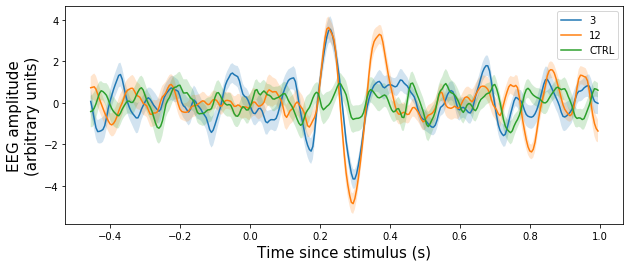

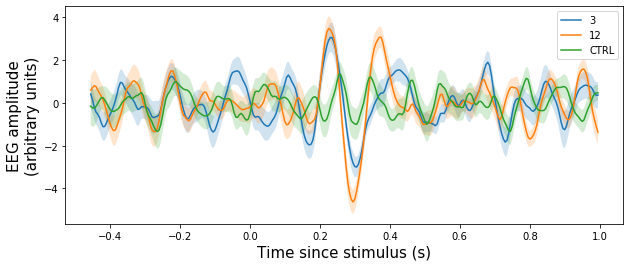

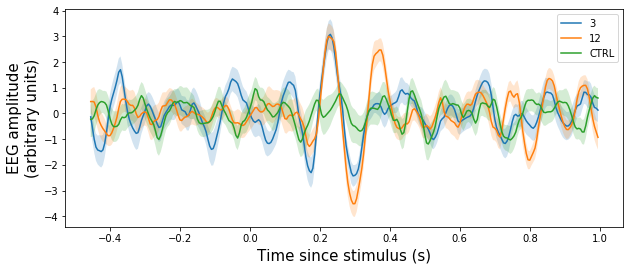

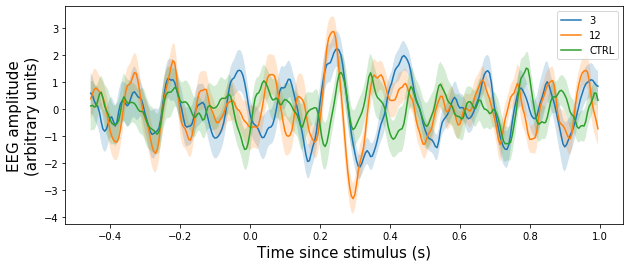

In [81]:
for i in range(4):
    plt.figure(figsize=(10,4))
    #plt.subplot(1,4,i+1)
    for t in range(len(np.unique(trial_types))):
        #rec = np.mean(eeg_trials[i][trial_types==(t+1)], axis=0)
        #rec = moving_average(rec, n=N_AVG)
        x= time[(N_AVG-1):]
        y= np.mean(eeg_trials_smooth[i][trial_types==(t+1)],axis=0)
        err= np.std(eeg_trials_smooth[i][trial_types==(t+1)],axis=0) / np.sqrt(eeg_trials_smooth[i][trial_types==(t+1)].shape[0])
        plt.plot(x, y)
        plt.fill_between(x, y-err, y+err, alpha=0.2, linewidth=4)
        plt.legend(values)    
    plt.xlabel('Time since stimulus (s)', fontsize=15)
    plt.ylabel('EEG amplitude\n(arbitrary units)', fontsize=15)
    plt.savefig('./amplt_by_time_ch{}.png'.format(i))

In [102]:
def get_power_spect(data):
    spec_PSDperHz, _, _ = mlab.specgram(data, NFFT=164, window=mlab.window_hanning, Fs=fs_Hz, noverlap=28)
    return spec_PSDperHz.mean(axis=1)

In [103]:
eeg_spect = np.apply_along_axis(get_power_spect, axis=2, arr=eeg_trials)

/Users/fahd/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Only one segment is calculated since parameter NFFT (=164) >= signal length (=100).
  


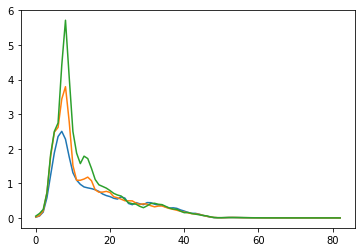

In [104]:
plt.plot(eeg_spect.mean(axis=0)[trial_types==1].mean(axis=0))
plt.plot(eeg_spect.mean(axis=0)[trial_types==2].mean(axis=0))
plt.plot(eeg_spect.mean(axis=0)[trial_types==3].mean(axis=0))

In [105]:
# channels are concatenated horizontally
eeg_trials_X = eeg_trials.swapaxes(0,1).reshape((eeg_trials.shape[1], eeg_trials.shape[0]*eeg_trials.shape[2])) 
eeg_trials_Y = trial_types 

In [106]:
eeg_spect_X = eeg_spect.swapaxes(0,1).reshape((eeg_spect.shape[1], eeg_spect.shape[0]*eeg_spect.shape[2]))
eeg_trials_X = np.concatenate([eeg_trials_X, eeg_spect_X], axis=1)

In [57]:
eeg_trials_X = np.concatenate(eeg_trials, axis=0)
eeg_trials_Y = np.repeat(trial_types, 4)

In [58]:
#eeg_trials_C = np.concatenate([np.repeat(i, eeg_trials.shape[1]) for i in [1,2,3,4]])

In [107]:
eeg_trials_X_smooth = np.vstack([moving_average(eeg_trials_X[r,:], n=10) for r in range(eeg_trials_X.shape[0])])

In [108]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(eeg_trials_X_smooth, eeg_trials_Y, stratify=eeg_trials_Y, test_size=.3)

model = LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto')
scores = cross_val_score(model, X=eeg_trials_X_smooth, y=eeg_trials_Y, scoring='accuracy', cv=5)

In [109]:
scores.mean()

0.4533333333333333

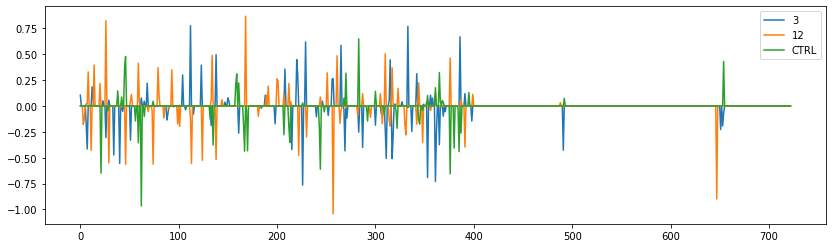

In [110]:
model.fit(eeg_trials_X_smooth, eeg_trials_Y)
plt.figure(figsize=(14, 4))
plt.plot(model.coef_.T)
plt.legend(values)

In [111]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=2000, oob_score=True)
scores = cross_val_score(model, X=eeg_trials_X_smooth, y=eeg_trials_Y, scoring='accuracy', cv=5)
scores.mean()

0.52

In [70]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.4666666666666667

In [256]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=2000)
scores = cross_val_score(model, X=eeg_trials_X[np.isin(eeg_trials_Y, [1,2])], y=eeg_trials_Y[np.isin(eeg_trials_Y, [1,2])], scoring='accuracy', cv=5)
scores.mean()

0.57